<a href="https://colab.research.google.com/github/TamiBorges/Controlando-Rotatividade-das-empresas/blob/main/Identifica%C3%A7%C3%A3o_de_doen%C3%A7as_respirat%C3%B3rias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Identificação de doenças respiratórias**

**Neste caso, faremos o estudo de detecção de doenças respiratórias, por imagens, através do machine learning, mais propriamente o deep learning**.

Recebemos 133 imagens de raixo-x da equipe médica, e precisaremos identificar qual das 4 classes abaixo, as imagens pertencem:

*   Healthy (saudável)
*   Covid-19
*   Bacterial Pneumonia
*   Viral Pneumonia





## **Importação das bibliotecas e base de dados**

*Neste caso importamos varias bibliotecas porque iremos trabalhar com redes neurais convolucionais, onde será necessário varias bibliotecas específias.*

In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, AveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

*Agora faremos uma conexão com o google drive porque a base de dados que vamos trabalhar neste caso, é muito grande e vai tomar muito tempo para o carregamento, então sempre que formos trabalhar com dados muito grandes, podemos armazená-lo no google drive, e acessar pelo Colab.*

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
diretorio_imagens='/content/drive/MyDrive/Ciência de Dados para Empresas e Negócios/Departamento médico/Dataset'

In [6]:
os.listdir(diretorio_imagens)

['.DS_Store', '2', '3', '1', '0']

In [7]:
image_generator= ImageDataGenerator(rescale= 1./255)

In [8]:
train_generator= image_generator.flow_from_directory(batch_size= 40, directory=diretorio_imagens,
                                                           shuffle= True, target_size= (256, 256), 
                                                           class_mode= 'categorical', subset= 'training')

Found 532 images belonging to 4 classes.


In [9]:
train_images, train_labels= next(train_generator)

In [10]:
train_images.shape

(40, 256, 256, 3)

In [11]:
train_labels

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]],

*Acima podemos ver a primeira linha [0., 1., 0., 0.] quer dizer que a imagem é referente a um resultado saudável ou normal, já na terceira linha [1., 0., 0., 0.], significa que a imagem representa positivo para Covid-19.*

In [12]:
labels_names= {0: 'Covid-19', 1: 'Normal', 2: 'Pneumonia Viral', 3: 'Pneumonia Bacterial'}

## **Vizualização dos dados**

*O objetivo é fazer a leitura das imagens, listar e carregar.*

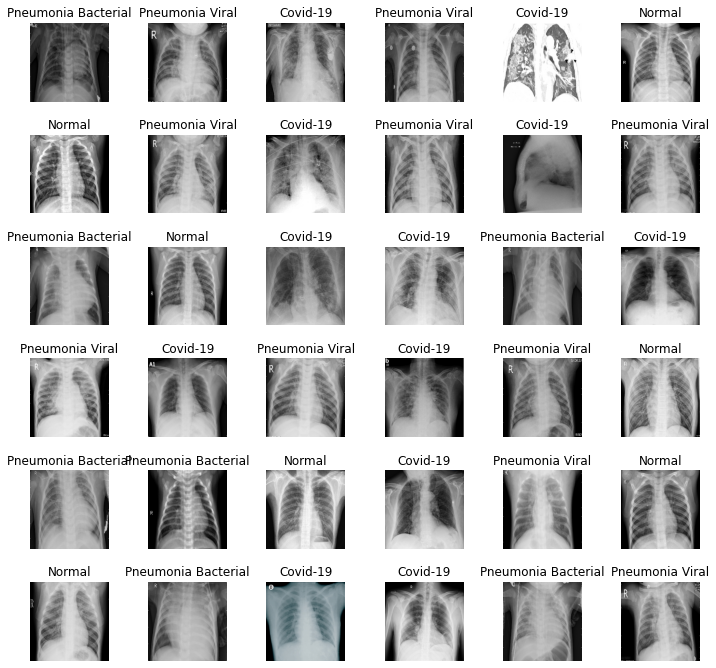

In [13]:
fig, axes= plt.subplots(6, 6, figsize=(12, 12))
axes = axes.ravel()
for i in np.arange(0, 36):
  axes[i].imshow(train_images[i])
  axes[i].set_title(labels_names[np.argmax(train_labels[i])])
  axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)


## **Carregamento da rede neural com pesos pré-treinados**

In [14]:
base_model = ResNet50(weights='imagenet', include_top=False,
                     input_tensor = Input(shape= (256,256,3)))

94781440/94765736 [==============================] - 1s 0us/step


In [15]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

*ResNet50 é uma rede neural pré-treinada, então criamos uma variavel base_model que trará nosso estrutura base da nossa rede neural.*

In [16]:
len(base_model.layers)

175

*Precisaremos então congelar esses pesos da rede pré-treinada, para que ela não entre no nosso treinamento.*

In [17]:
for layer in base_model.layers[:-10]:
  layers.trainable = False

## **Construção e treinamento do modelo de deep learning**

In [18]:
head_model= base_model.output
head_model= AveragePooling2D()(head_model)
head_model= Flatten()(head_model)
head_model= Dense(256, activation='relu')(head_model)
head_model= Dropout(0.2)(head_model)
head_model= Dense(128, activation='relu')(head_model)
head_model= Dropout(0.2)(head_model)
head_model= Dense(4, activation='softmax')(head_model)

*Então temos nossa camada de entrada transformando matriz para vetor, ligada na primeira camada densa com 256 neorônios, que esta ligado a segunda camada densa oculta com mais 256 neorônios, por fim a camada de saída com 4 neorônios, porque estamos trabalhando com 4 classes.*

In [19]:
model= Model(inputs = base_model.input , outputs = head_model)

*Ou seja, a entrada na nossa rede será base_model, e a saída será head_model.*

In [20]:
model.compile(loss= 'categorical_crossentropy', optimizer= optimizers.RMSprop(lr=1e-4, decay=1e-6),
              metrics= ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [21]:
checkpointer= ModelCheckpoint(filepath= 'weights.hdf5')

In [22]:
train_generator= image_generator.flow_from_directory(batch_size= 4, directory=diretorio_imagens,
                                                           shuffle= True, target_size= (256, 256), 
                                                           class_mode= 'categorical', subset= 'training')

Found 532 images belonging to 4 classes.


In [23]:
history= model.fit_generator(train_generator, epochs=25, callbacks= [checkpointer])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/25
133/133 [==============================] - 528s 4s/step - loss: 1.1089 - accuracy: 0.7011
Epoch 2/25
133/133 [==============================] - 509s 4s/step - loss: 0.5063 - accuracy: 0.8684
Epoch 3/25
133/133 [==============================] - 503s 4s/step - loss: 0.3657 - accuracy: 0.9192
Epoch 4/25
133/133 [==============================] - 514s 4s/step - loss: 0.2777 - accuracy: 0.9361
Epoch 5/25
133/133 [==============================] - 508s 4s/step - loss: 0.3292 - accuracy: 0.9305
Epoch 6/25
133/133 [==============================] - 519s 4s/step - loss: 0.1180 - accuracy: 0.9737
Epoch 7/25
133/133 [==============================] - 514s 4s/step - loss: 0.1492 - accuracy: 0.9737
Epoch 8/25
133/133 [==============================] - 513s 4s/step - loss: 0.1723 - accuracy: 0.9756
Epoch 9/25
133/133 [==============================] - 517s 4s/step - loss: 0.2217 - accuracy: 0.9793
Epoch 10/25
133/133 [==============================] - 503s 4s/step - loss: 0.0192 - accura

*Podemos observar que o loss diminuiu e o accuracy teve um aumento, mas ainda não podemos levar estes valores em consideração, pois são apenas os dados de treinamento. Para avaliar o modelo precisaremos de dados novos.*

## **Avaliação da rede neural**

In [24]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

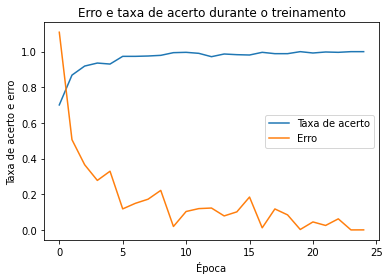

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Erro e taxa de acerto durante o treinamento')
plt.xlabel('Época')
plt.ylabel('Taxa de acerto e erro')
plt.legend(['Taxa de acerto', 'Erro']);

*O gráfico acima nos dá a noção de como fica os valores de loss e accuracy de acordo com o andamento da execução do treinamento. Mas esses dados ainda não são uteis pois estes dados são apenas de treinamento. Portanto precisamos fazer este procedimento com a base de teste.*

In [26]:
diretorio_teste= ('/content/drive/MyDrive/Ciência de Dados para Empresas e Negócios/Departamento médico/Test')

In [27]:
test_gen= ImageDataGenerator(rescale= 1./255)
test_generator= test_gen.flow_from_directory(batch_size=40, directory= diretorio_teste,
                                             shuffle= True, target_size= (256, 256),
                                             class_mode= 'categorical')

Found 40 images belonging to 4 classes.


In [28]:
avaliação= model.evaluate_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
avaliação

*Agora faremos uma codificação para gerar as previsões e respostas reais, com o objetivo de gerar a matriz de confusão e fazer analise classe por classe.*

In [30]:
prediction= []
original= []
image= []

for i in range (len(os.listdir(diretorio_teste))):
  for item in os.listdir(os.path.join(diretorio_teste, str(i))):
    img= cv2.imread(os.path.join(diretorio_teste, str(i), item))
    img= cv2.resize(img, (256,256))
    image.append(img)
    img= img / 255
    img= img.reshape(-1, 256, 256, 3)
    predict= model.predict(img)
    predict= np.argmax(predict)
    prediction.append(predict)
    original.append(i)

In [31]:
print(prediction)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 0, 2, 1, 3, 2, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1]


In [32]:
print(original)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


*Podemos observar que foi gerado as previsões e também temos os valores reais, sendo possível ja fazermos um comparativo entre os vetores, para calcularmos o accuracy e gerar a matriz de confusão.*

In [33]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [34]:
accuracy_score(original, prediction)

0.8

*Agora podemos gerar o conjunto de imagens com valores de previsão e valores reais.*

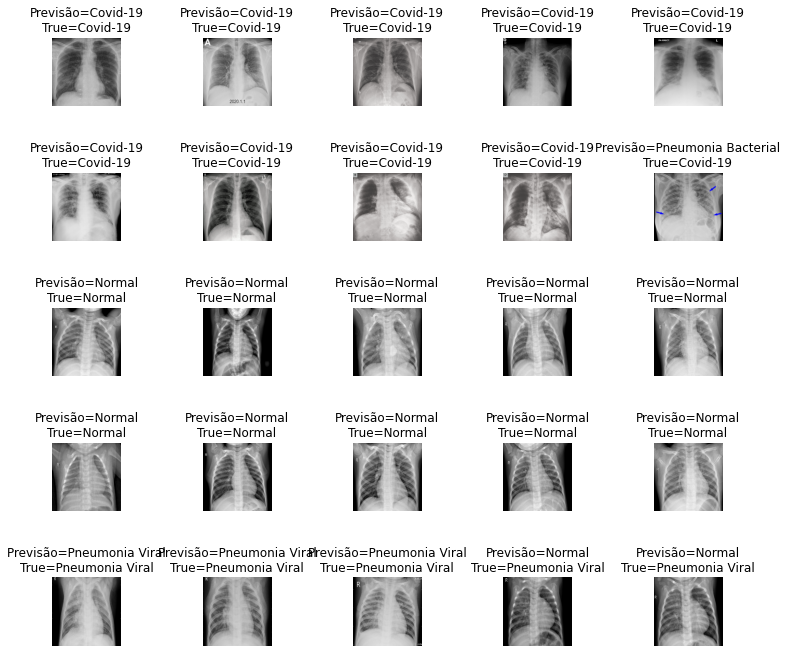

In [37]:
fig, axes= plt.subplots(5, 5, figsize=(12,12))
axes= axes.ravel()
for i in np.arange(0, 25):
  axes[i].imshow(image[i])
  axes[i].set_title('Previsão={}\nTrue={}'.format(str(labels_names[prediction[i]]), str(labels_names[original[i]])))
  axes[i].axis('off')
plt.subplots_adjust(wspace= 1.2)


*É possível vermos que em muitas imagens a previsão esta correta, mas, em algumas há erro.*

In [39]:
labels_names

{0: 'Covid-19', 1: 'Normal', 2: 'Pneumonia Viral', 3: 'Pneumonia Bacterial'}

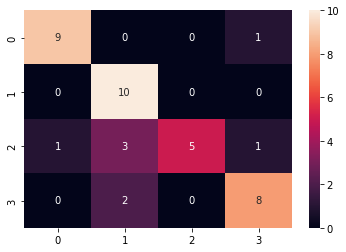

In [38]:
cm= confusion_matrix(original, prediction)
sns.heatmap(cm, annot=True);

*Levando em consideração que temos poucos dados, podemos afimar que o desempenho esta bom, pois por exemplo, para a classe 0 (Covid-19) ele errou apenas 1, para classe 1 (normal) acertou todos.*

In [40]:
print(classification_report(original, prediction))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.67      1.00      0.80        10
           2       1.00      0.50      0.67        10
           3       0.80      0.80      0.80        10

    accuracy                           0.80        40
   macro avg       0.84      0.80      0.79        40
weighted avg       0.84      0.80      0.79        40



*Podemos fazer a interpretação dos valores do precision e recall para as classes, por exemplo, para classe 0 (Covid-19), recall=0.9, ou seja o modelo identifica corretamente 90% dos pacientes com covid. Já para classe 3 (pneumonia bacterial) no recall o modelo identifica corretamente 80% dos pacientes, e no precision ele diz que nestes casos ele acerta 80 das vezes, ou 80% correto do resultado.*

**Classificação de apenas uma imagem**

*Depois que estivermos satisfeitos com os resultados do nosso modelo, podemos enviar esse modelo pronto para ser usado em produção, através do arquivo que salvamos os pesos.* 

In [43]:
from keras.models import load_model
modelo_carregado= load_model('/content/weights.hdf5')

*Não é necessário fazermos todo treinamento novamente, podemos apenas carregar o modelo.*

In [45]:
modelo_carregado.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

*Vamos fazer um teste com uma imagem:*

In [46]:
img= cv2.imread('/content/drive/MyDrive/Ciência de Dados para Empresas e Negócios/Departamento médico/Test/0/auntminnie-d-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg')

In [47]:
img, img.shape

(array([[[253, 253, 253],
         [254, 254, 254],
         [252, 252, 252],
         ...,
         [249, 249, 249],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[236, 238, 238],
         [237, 239, 239],
         [236, 238, 238],
         ...,
         [242, 242, 242],
         [229, 229, 229],
         [245, 245, 245]],
 
        [[177, 179, 179],
         [179, 181, 181],
         [178, 180, 180],
         ...,
         [ 81,  81,  81],
         [ 75,  75,  75],
         [171, 171, 171]],
 
        ...,
 
        [[124, 120, 119],
         [102,  98,  97],
         [103,  99,  98],
         ...,
         [ 71,  69,  69],
         [ 51,  49,  49],
         [170, 168, 168]],
 
        [[128, 123, 124],
         [ 99,  94,  95],
         [106, 101, 102],
         ...,
         [ 68,  66,  66],
         [ 52,  50,  50],
         [171, 169, 169]],
 
        [[130, 125, 126],
         [100,  95,  96],
         [107, 102, 103],
         ...,
         [ 68,  66,  66],
  

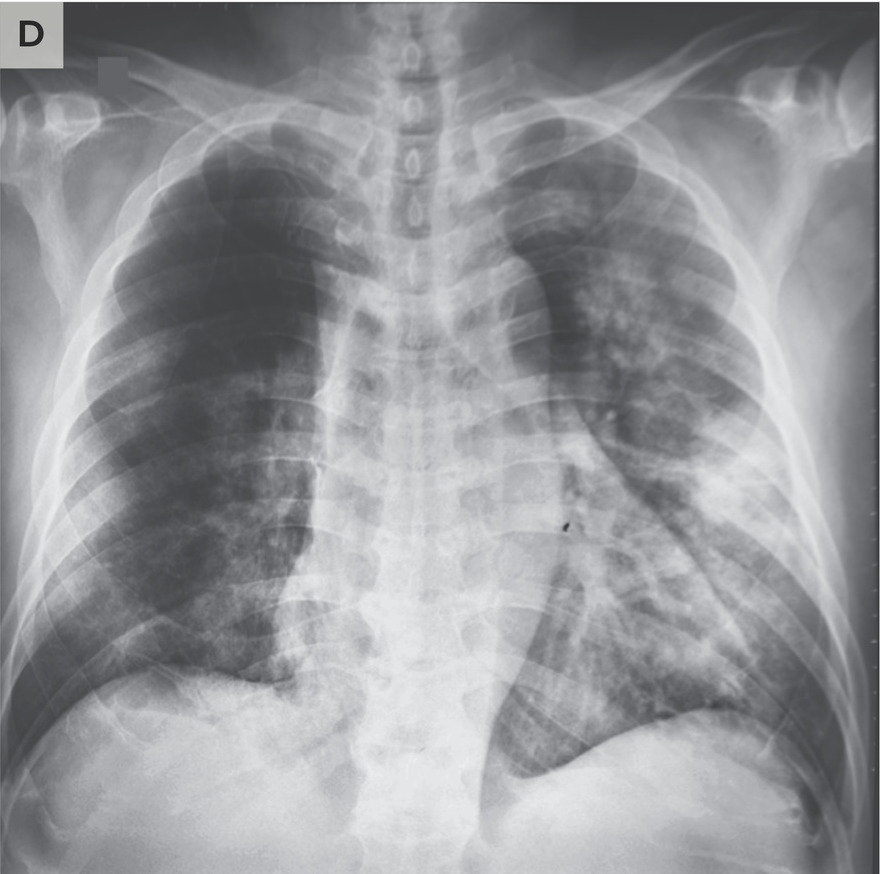

In [48]:
from google.colab.patches import cv2_imshow
cv2_imshow(img)

*Precisamos redimensionar esta imagem.*

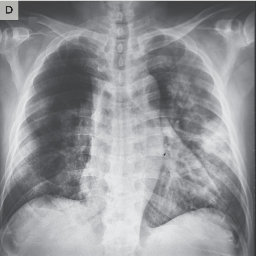

In [49]:
img= cv2.resize(img, (256,256))
cv2_imshow(img)

*Importante redimensionar as escalas entre 0 e 1 , conforme abaixo, sempre que trabalharmos com processamento de redes neurais, porque ao contrário a rede demora muito para atualizar os pesos, por causa das escalas.*

In [50]:
img= img/255
img

array([[[0.88235294, 0.89019608, 0.89019608],
        [0.88235294, 0.89019608, 0.89019608],
        [0.87843137, 0.89019608, 0.89019608],
        ...,
        [0.79607843, 0.79607843, 0.79607843],
        [0.8       , 0.79607843, 0.79607843],
        [0.78431373, 0.78431373, 0.78431373]],

       [[0.68627451, 0.70588235, 0.70196078],
        [0.68627451, 0.70588235, 0.70196078],
        [0.68235294, 0.70196078, 0.69803922],
        ...,
        [0.2627451 , 0.25882353, 0.25882353],
        [0.26666667, 0.2627451 , 0.2627451 ],
        [0.22352941, 0.22352941, 0.22352941]],

       [[0.68627451, 0.70588235, 0.70196078],
        [0.68627451, 0.70588235, 0.70196078],
        [0.68627451, 0.70588235, 0.70196078],
        ...,
        [0.26666667, 0.25882353, 0.25882353],
        [0.2627451 , 0.25490196, 0.25098039],
        [0.20784314, 0.20784314, 0.20784314]],

       ...,

       [[0.41568627, 0.4       , 0.39607843],
        [0.41176471, 0.39607843, 0.39215686],
        [0.43921569, 0

In [51]:
img.shape

(256, 256, 3)

In [52]:
img= img.reshape(-1, 256, 256, 3)
img.shape

(1, 256, 256, 3)

In [53]:
previsão= modelo_carregado(img)
previsão

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[1.0000000e+00, 9.2227811e-21, 1.0161016e-20, 5.9477250e-22]],
      dtype=float32)>

In [54]:
previsão= np.argmax(previsão)
previsão

0

In [55]:
labels_names[previsão]

'Covid-19'

*Fazendo a previsão desta imagem carregada, conseguimos observar que o modelo previu este paciente com Covid-19.*